In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
from skimage.color import rgb2gray

import cv2
import heapq
from collections import defaultdict, Counter
import pickle

import torch
import torchvision.transforms as transforms
from PIL import Image
from compressai.zoo import models
from datetime import datetime

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Load images from Oxford Pets dataset directory
dataset_dir = "data/images"  # Update this with the correct path
image_files = os.listdir(dataset_dir)
# Select the first 5 images (assuming they are in .jpg or .png format)
sample_images = []
sample_images_gray = []
for i, file in enumerate(image_files[:5]):
    if file.endswith(('.jpg', '.png')):
        image_path = os.path.join(dataset_dir, file)
        image = io.imread(image_path)
        image_grey = rgb2gray(image)  # Convert to grayscale for simplicity
        sample_images.append(image)
        sample_images_gray.append(image_grey)

# SVD image compression

Singular Value Decomposition (SVD) is a very powerful and useful technique used for data dimensionality reduction and image compression. In this context, it reduces the storage requirements by approximating an image while preserving its most prominent visual features.

Here's a step-by-step explanation of how SVD image compression works:
1. We first represent the grayscale image as a 2D matrix $A$, where each element is representative of a pixel's intensity at the specific position.

2. We then decompose the matrix $A$ into three matrices: $A = USV^T$. $U$ is an orthogonal matrix representing the left singular vectors, $S$ is a diagonal matrix containing the singular values (which can be thought of as the important feature weights), and $V^T$ is an orthogonal matrix representing the right singular vectors.

3. We would then select some value $k$ to represent the number of singular values to retain. We note the trucated image representation retaining the $k$ top singular values as $A_k$. This means our new representation is $A_k = U_kS_kV_k^T$. Our goal is to make it so that $A_k$ (which would include the sizes of $U_k$, $S_k$, and $V_k$) is less in size than the original image file $A$.

**Explanation of the Code**: In the provided code below,  We first have an inout of the grayscale images that are being processed using SVD. Then for each image, we choose different $k$ values to determine the number of singular values to retain and then sicualize the original images with their compressed counterparts and then print the sizes for comparison.

Compression with k = 5
Image 1:
  Original size: 187500 elements
  Compressed size: 4400 elements
Image 2:
  Original size: 197000 elements
  Compressed size: 4495 elements
Image 3:
  Original size: 166500 elements
  Compressed size: 4190 elements
Image 4:
  Original size: 270050 elements
  Compressed size: 5230 elements
Image 5:
  Original size: 200500 elements
  Compressed size: 4530 elements



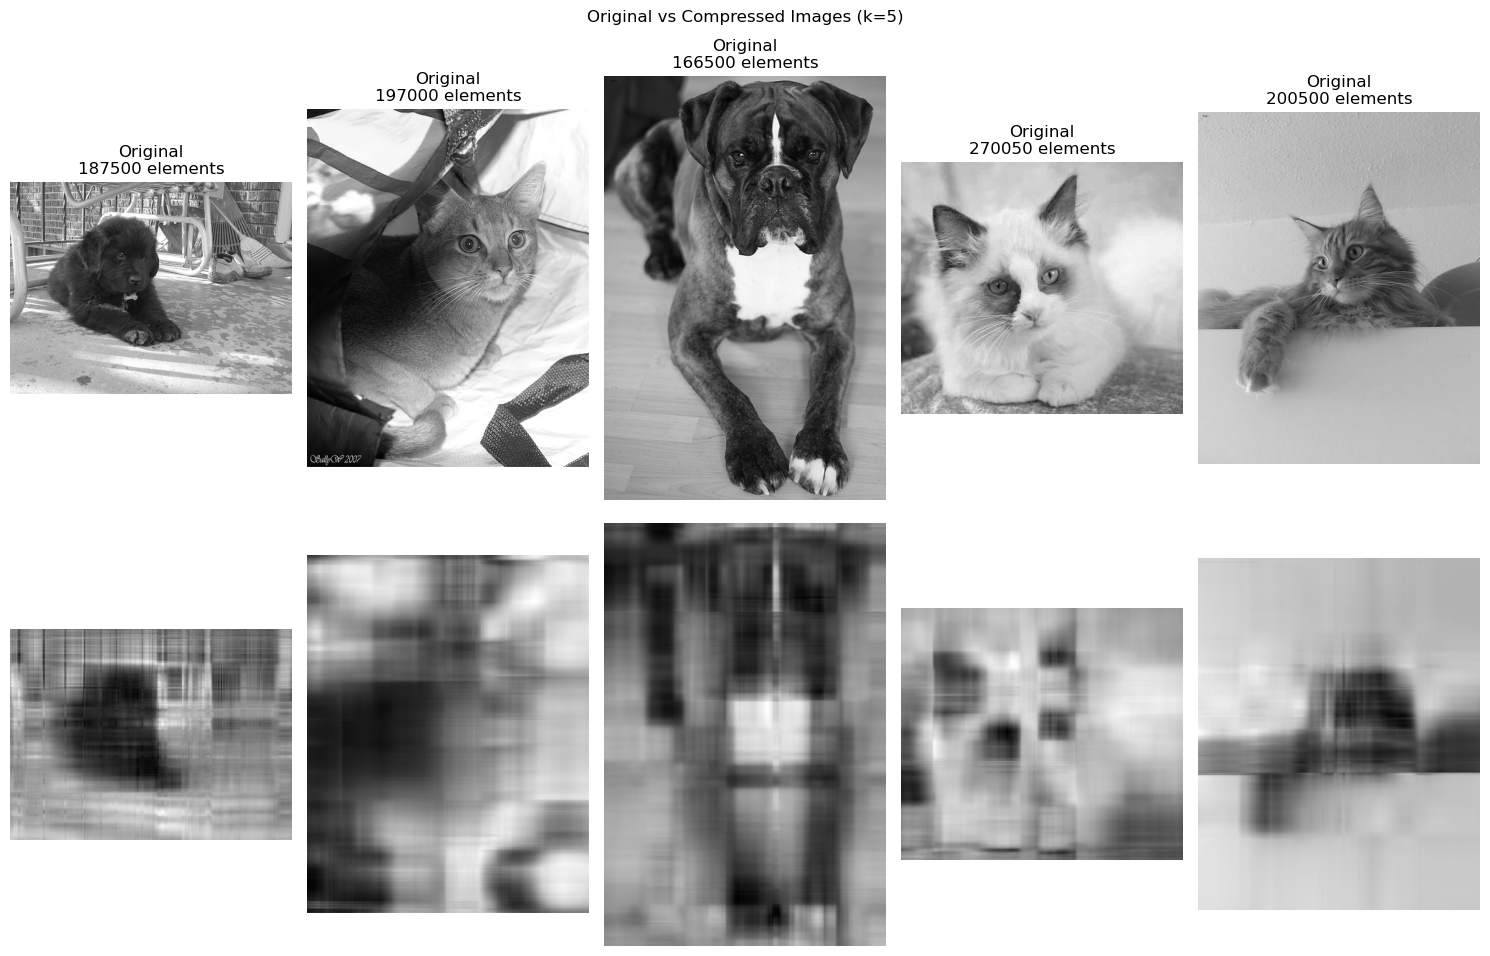

Compression with k = 10
Image 1:
  Original size: 187500 elements
  Compressed size: 8850 elements
Image 2:
  Original size: 197000 elements
  Compressed size: 9040 elements
Image 3:
  Original size: 166500 elements
  Compressed size: 8430 elements
Image 4:
  Original size: 270050 elements
  Compressed size: 10510 elements
Image 5:
  Original size: 200500 elements
  Compressed size: 9110 elements



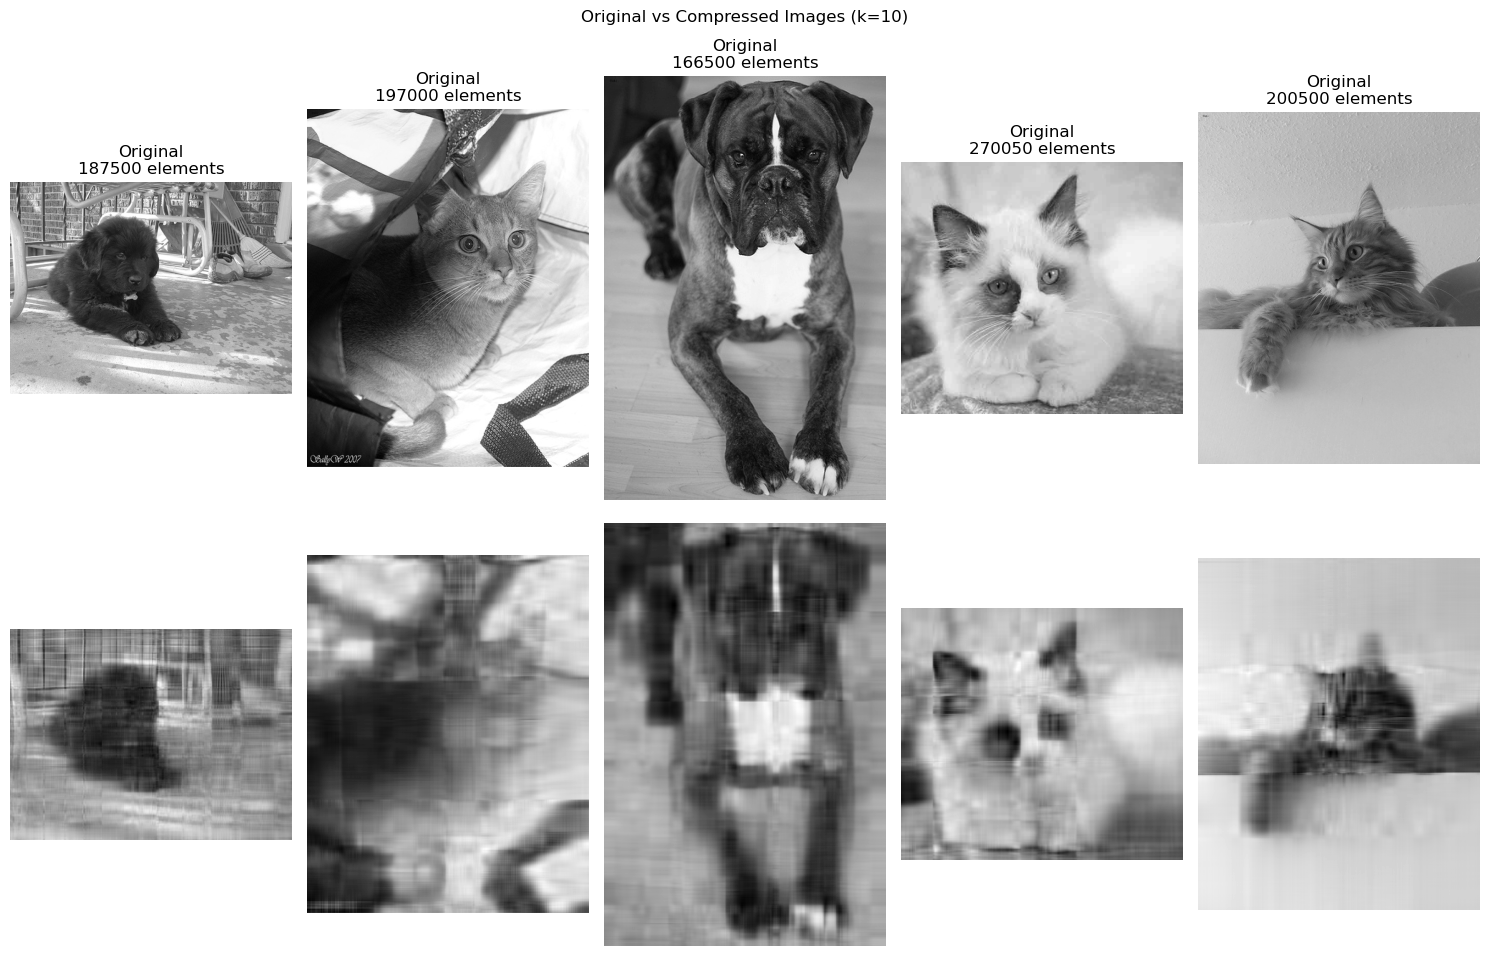

Compression with k = 20
Image 1:
  Original size: 187500 elements
  Compressed size: 17900 elements
Image 2:
  Original size: 197000 elements
  Compressed size: 18280 elements
Image 3:
  Original size: 166500 elements
  Compressed size: 17060 elements
Image 4:
  Original size: 270050 elements
  Compressed size: 21220 elements
Image 5:
  Original size: 200500 elements
  Compressed size: 18420 elements



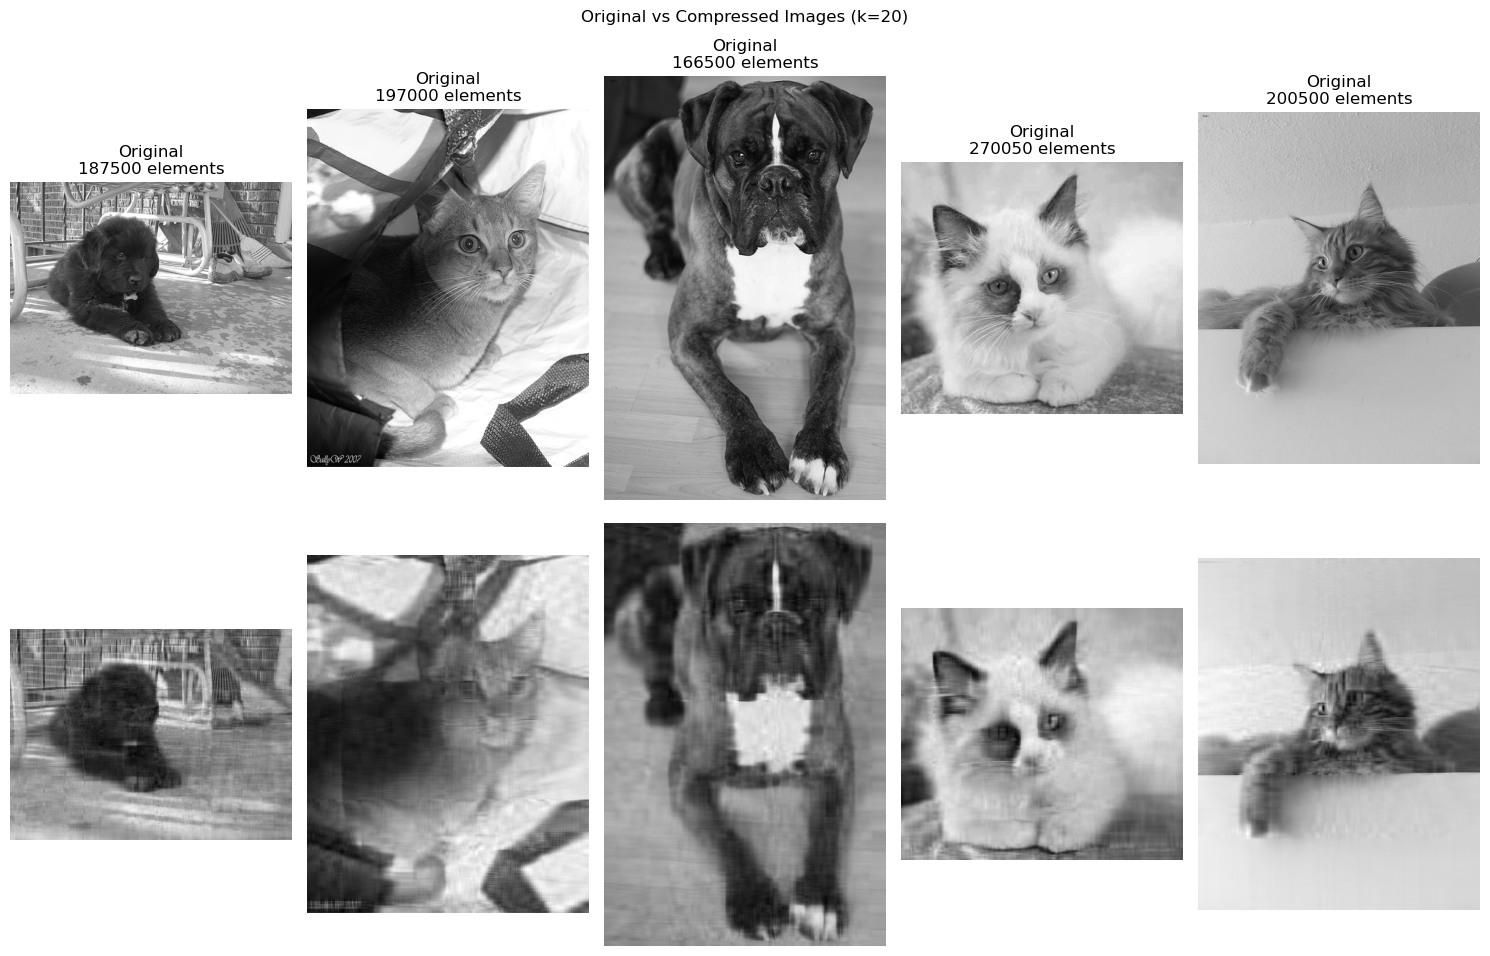

Compression with k = 40
Image 1:
  Original size: 187500 elements
  Compressed size: 36600 elements
Image 2:
  Original size: 197000 elements
  Compressed size: 37360 elements
Image 3:
  Original size: 166500 elements
  Compressed size: 34920 elements
Image 4:
  Original size: 270050 elements
  Compressed size: 43240 elements
Image 5:
  Original size: 200500 elements
  Compressed size: 37640 elements



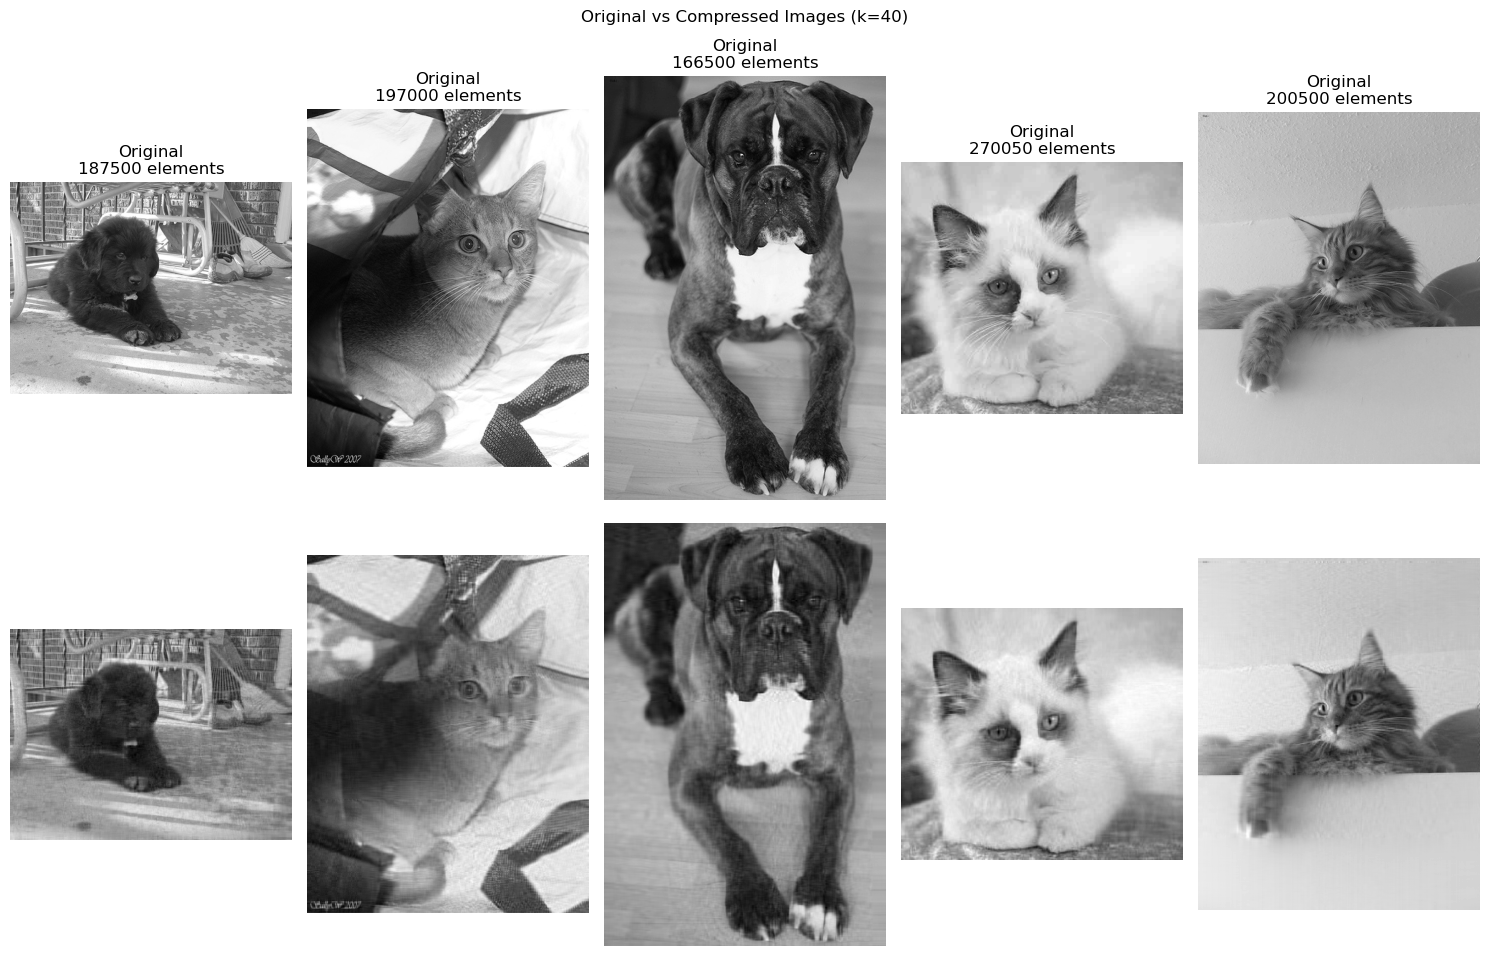

In [3]:
def svd_compress(image, k):
    U, S, VT = np.linalg.svd(image, full_matrices=False)
    S = np.diag(S)
    # Retain only the top k singular values
    U_k = U[:, :k]
    S_k = S[:k, :k]
    VT_k = VT[:k, :]
    # Reconstruct the compressed image
    compressed_image = np.dot(U_k, np.dot(S_k, VT_k))
    return U_k, S_k, VT_k, compressed_image

# Adjusted k-values for 32x32 images
k_values = [5, 10, 20, 40]

# Display original and compressed images with sizes
for k in k_values:
    print(f"Compression with k = {k}")
    plt.figure(figsize=(15, 10))

    for i, image in enumerate(sample_images_gray):
        # Original image
        original_size = image.size  # Total pixels in the original image
        plt.subplot(2, len(sample_images_gray), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Original\n{original_size} elements")
        plt.axis('off')

        # Compressed image
        U_k, S_k, VT_k, compressed_image = svd_compress(image, k)
        compressed_size = U_k.size + S_k.size + VT_k.size  # Total elements in compressed representation

        plt.subplot(2, len(sample_images_gray), i + 1 + len(sample_images_gray))
        plt.imshow(compressed_image, cmap='gray')
        plt.axis('off')

        # Print sizes in the console
        print(f"Image {i + 1}:")
        print(f"  Original size: {original_size} elements")
        print(f"  Compressed size: {compressed_size} elements")
    print()
    plt.suptitle(f"Original vs Compressed Images (k={k})")
    plt.tight_layout()
    plt.show()

# Huffman Coding

Huffman coding is a popular algorithm used for lossless data compression. The basic idea is to assign variable-length codes to input characters, with shorter codes assigned to more frequent characters. This way, the overall length of the encoded data is minimized.

Here's a step-by-step explanation of how Huffman coding works:

1. Frequency Calculation: Calculate the frequency of each character in the input data.

2. Priority Queue: Create a priority queue (or a min-heap) and insert all characters with their frequencies. Each character is treated as a leaf node of a tree.

3. Tree Construction:

    - While there is more than one node in the queue:
        - Remove the two nodes with the lowest frequency from the queue.
        - Create a new internal node with these two nodes as children and with a frequency equal to the sum of their frequencies.
        - Insert the new node back into the queue.
    - The remaining node is the root of the Huffman tree.
4. Code Assignment: Traverse the Huffman tree and assign codes to characters:

    - Assign '0' for the left edge and '1' for the right edge.
    - The code for each character is the sequence of edges from the root to the leaf node representing that character.
5. Encoding: Replace each character in the input data with its corresponding Huffman code.

6. Decoding: Use the Huffman tree to decode the encoded data by traversing the tree according to the sequence of bits.



In [4]:
# Define the Node class for the Huffman tree
class Node:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

# Function to build the Huffman tree
def build_huffman_tree(frequency):
    heap = [Node(char, freq) for char, freq in frequency.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)

    return heap[0]

# Function to build the Huffman codes
def build_codes(node, prefix="", codebook={}):
    if node is not None:
        if node.char is not None:
            codebook[node.char] = prefix
        build_codes(node.left, prefix + "0", codebook)
        build_codes(node.right, prefix + "1", codebook)
    return codebook

# Function to encode the image using Huffman coding
def huffman_encoding(image):
    # Normalize and quantize to integers if image is in 0-1 range
    if image.dtype == np.float64 or image.dtype == np.float32:
        image = (image * 255).astype(np.uint8)
    
    flat_image = image.flatten()
    frequency = Counter(flat_image)
    root = build_huffman_tree(frequency)
    codebook = build_codes(root)
    encoded_image = ''.join(codebook[pixel] for pixel in flat_image)
    return encoded_image, root, image.shape

# Function to decode the Huffman encoded image
def huffman_decoding(encoded_image, root, shape):
    decoded_image = []
    node = root
    for bit in encoded_image:
        node = node.left if bit == '0' else node.right
        if node.char is not None:
            decoded_image.append(node.char)
            node = root
    decoded_image = np.array(decoded_image, dtype=np.uint8).reshape(shape)
    return decoded_image


# # Example usage
# image_path = '0.png'
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

# encoded_image, tree, shape = huffman_encoding(image)
# decoded_image = huffman_decoding(encoded_image, tree, shape)


# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title("Original Image")
# plt.imshow(image, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title("Decoded Image")
# plt.imshow(decoded_image, cmap='gray')
# plt.axis('off')

# plt.show()


Image 1 compression details:
Original size: 1,500,000 bytes
Encoded data: 177,094 bytes
Tree structure: 13,023 bytes
Shape information: 16 bytes
Compression ratio: 7.89x

Image 2 compression details:
Original size: 1,576,000 bytes
Encoded data: 192,522 bytes
Tree structure: 14,704 bytes
Shape information: 16 bytes
Compression ratio: 7.60x

Image 3 compression details:
Original size: 1,332,000 bytes
Encoded data: 157,728 bytes
Tree structure: 14,433 bytes
Shape information: 16 bytes
Compression ratio: 7.74x

Image 4 compression details:
Original size: 2,160,400 bytes
Encoded data: 239,492 bytes
Tree structure: 14,133 bytes
Shape information: 16 bytes
Compression ratio: 8.52x

Image 5 compression details:
Original size: 1,604,000 bytes
Encoded data: 167,749 bytes
Tree structure: 13,271 bytes
Shape information: 16 bytes
Compression ratio: 8.86x


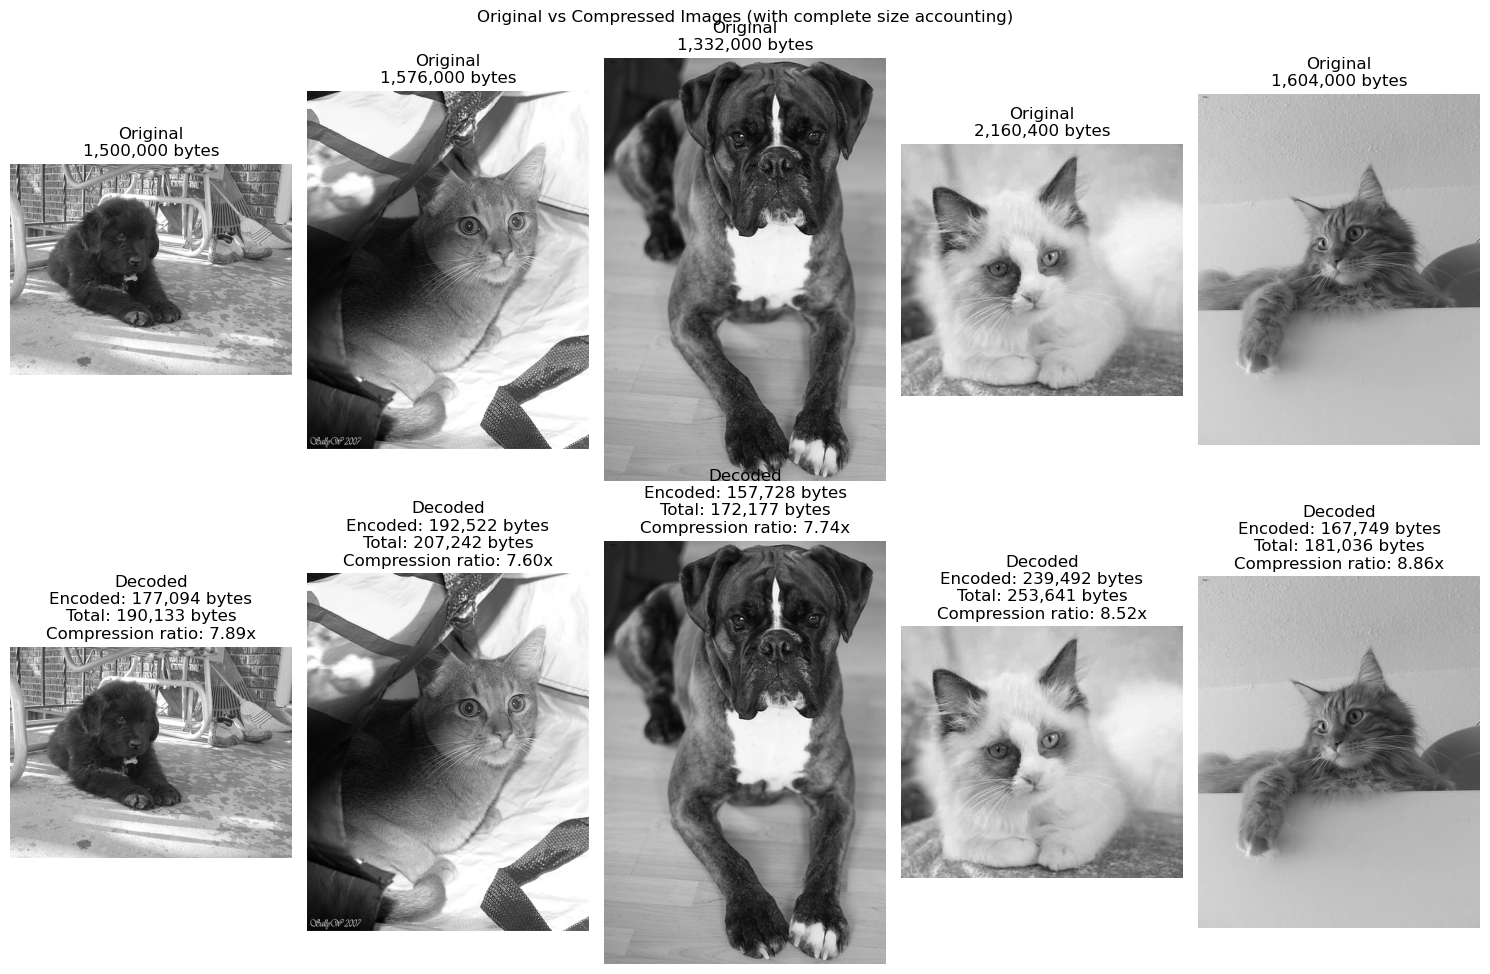

In [5]:
def get_tree_size_bytes(tree):
    """Calculate the size of the Huffman tree in bytes using pickle"""
    return len(pickle.dumps(tree))

def get_shape_size_bytes(shape):
    """Calculate the size of the shape tuple in bytes"""
    return len(shape) * np.dtype(np.int64).itemsize  # Each dimension stored as 64-bit integer

plt.figure(figsize=(15, 10))
for i, img in enumerate(sample_images_gray):
    # Encode image
    encoded_image, tree, shape = huffman_encoding(img)
    
    # Calculate sizes
    encoded_size = len(encoded_image) // 8  # Convert bits to bytes
    tree_size = get_tree_size_bytes(tree)
    shape_size = get_shape_size_bytes(shape)
    total_compressed_size = encoded_size + tree_size + shape_size
    
    # Decode image
    decoded_image = huffman_decoding(encoded_image, tree, shape)
    
    # Calculate compression ratio using total size
    compression_ratio = img.nbytes / total_compressed_size
    
    # Display original image
    plt.subplot(2, len(sample_images_gray), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{img.nbytes:,} bytes")
    plt.axis('off')
    
    # Display decoded image with detailed size breakdown
    plt.subplot(2, len(sample_images), i + 1 + len(sample_images_gray))
    plt.imshow(decoded_image, cmap='gray')
    plt.title(f"Decoded\nEncoded: {encoded_size:,} bytes\n"
              f"Total: {total_compressed_size:,} bytes\n"
              f"Compression ratio: {compression_ratio:.2f}x")
    plt.axis('off')
    
    # Print detailed breakdown
    print(f"\nImage {i + 1} compression details:")
    print(f"Original size: {img.nbytes:,} bytes")
    print(f"Encoded data: {encoded_size:,} bytes")
    print(f"Tree structure: {tree_size:,} bytes")
    print(f"Shape information: {shape_size:,} bytes")
    print(f"Compression ratio: {compression_ratio:.2f}x")

plt.suptitle(f"Original vs Compressed Images (with complete size accounting)")
plt.tight_layout()
plt.show()

# Learned Image Compression (LIC)


In [6]:
def compress_image_with_pretrained(img, quality=1):
    """
    Compress an image using a pre-trained CompressAI model
    Handles both RGB and grayscale numpy arrays
    """
    # Convert numpy array to PIL Image if necessary
    if isinstance(img, np.ndarray):
        # Normalize to 0-255 range if in float
        if img.dtype == np.float64 or img.dtype == np.float32:
            img = (img * 255).astype(np.uint8)
        
        if len(img.shape) == 2:  # Grayscale
            img = Image.fromarray(img, mode='L')
        elif len(img.shape) == 3:  # RGB
            img = Image.fromarray(img, mode='RGB')
    
    # Convert grayscale to RGB for model
    if img.mode == 'L':
        img = img.convert('RGB')
    
    # Load model
    model = models['bmshj2018-factorized'](quality=quality, pretrained=True)
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Transform and pad
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    _, _, h, w = x.shape
    pad_h = (64 - (h % 64)) % 64
    pad_w = (64 - (w % 64)) % 64
    
    if pad_h > 0 or pad_w > 0:
        x = torch.nn.functional.pad(x, (0, pad_w, 0, pad_h))
    
    # Compress and decompress
    with torch.no_grad():
        compressed = model.compress(x)
        decompressed = model.decompress(compressed['strings'], compressed['shape'])
    
    # Post-process
    x_hat = decompressed['x_hat']
    if pad_h > 0 or pad_w > 0:
        x_hat = x_hat[:, :, :h, :w]
    
    # Convert back to PIL Image and then to grayscale if input was grayscale
    out_img = transforms.ToPILImage()(x_hat.squeeze().cpu().clamp_(0, 1))
    
    # always convert back to gray
    out_img = out_img.convert('L')
    
    # Calculate stats - handle both PIL Image and numpy array inputs
    if isinstance(img, np.ndarray):
        original_size = img.size * (1 if len(img.shape) == 2 else 3)
    else:  # PIL Image
        original_size = img.size[0] * img.size[1] * (1 if img.mode == 'L' else 3)
    
    compressed_size = sum(len(s[0]) for s in compressed['strings'])
    
    return {
        'quality': quality,
        'original_size_bytes': original_size,
        'compressed_size_bytes': compressed_size,
        'compression_ratio': original_size / compressed_size,
        'out_img': out_img
    }

def compare_quality_levels(img, qualities=[1, 4, 6, 8]):
    """
    Compare different quality levels of compression
    """
    results = []
    print("\nProcessing different quality levels:")
    print("-" * 60)
    print(f"{'Quality':<8} {'Original':<12} {'Compressed':<12} {'Ratio':<8}")
    print("-" * 60)
    
    for quality in qualities:
        result = compress_image_with_pretrained(
            img, 
            quality=quality
        )
        results.append(result)
        
        print(f"{quality:<8} "
              f"{result['original_size_bytes']/1024:>8.2f} KB "
              f"{result['compressed_size_bytes']/1024:>8.2f} KB "
              f"{result['compression_ratio']:>8.2f}x")
    return results


Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------


Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-1-446d5c7f.pth.tar" to /tmp/xdg-cache/torch/hub/checkpoints/bmshj2018-factorized-prior-1-446d5c7f.pth.tar
100%|██████████| 11.5M/11.5M [00:01<00:00, 9.29MB/s]
Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-4-1ed4405a.pth.tar" to /tmp/xdg-cache/torch/hub/checkpoints/bmshj2018-factorized-prior-4-1ed4405a.pth.tar


1          549.32 KB     3.54 KB   155.39x


100%|██████████| 11.6M/11.6M [00:00<00:00, 70.0MB/s]
Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-6-9b02ea3a.pth.tar" to /tmp/xdg-cache/torch/hub/checkpoints/bmshj2018-factorized-prior-6-9b02ea3a.pth.tar


4          549.32 KB    13.02 KB    42.19x


100%|██████████| 27.3M/27.3M [00:00<00:00, 51.2MB/s]
Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-8-5232faa3.pth.tar" to /tmp/xdg-cache/torch/hub/checkpoints/bmshj2018-factorized-prior-8-5232faa3.pth.tar


6          549.32 KB    31.63 KB    17.37x


100%|██████████| 27.9M/27.9M [00:00<00:00, 90.8MB/s]


8          549.32 KB    63.66 KB     8.63x

Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------
1          577.15 KB     2.77 KB   208.69x
4          577.15 KB     9.93 KB    58.12x
6          577.15 KB    23.44 KB    24.62x
8          577.15 KB    46.39 KB    12.44x

Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------
1          487.79 KB     2.28 KB   214.19x
4          487.79 KB     7.05 KB    69.14x
6          487.79 KB    15.47 KB    31.53x
8          487.79 KB    31.81 KB    15.34x

Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------
1

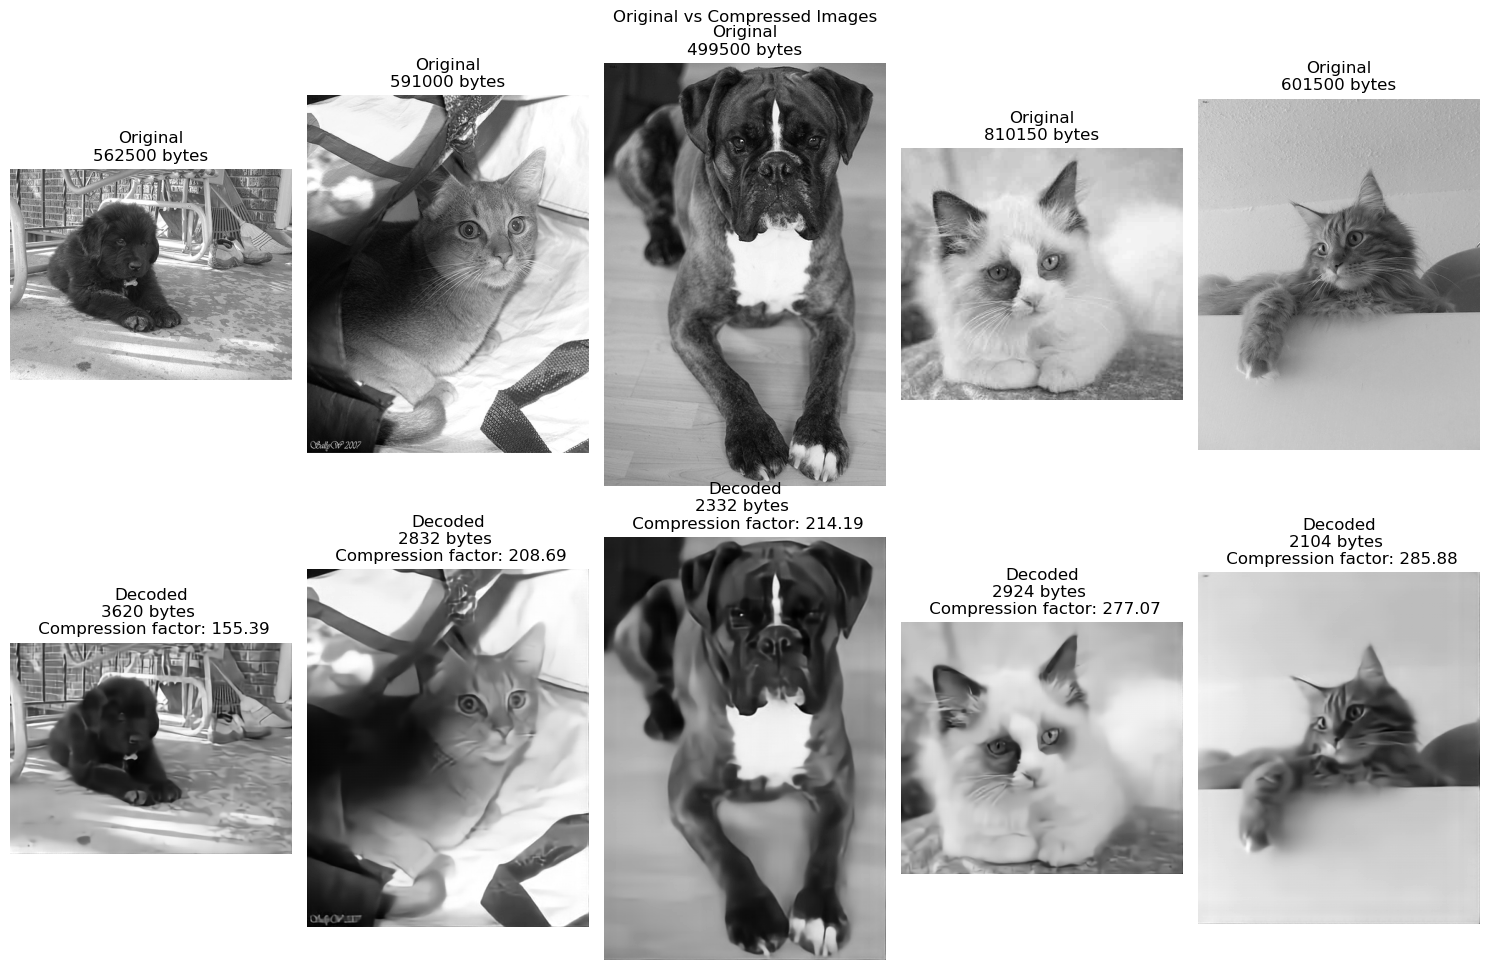

In [7]:
plt.figure(figsize=(15, 10))

for i, img in enumerate(sample_images_gray):
    # encoded_image, tree, shape = huffman_encoding(img)
    # decoded_image = huffman_decoding(encoded_image, tree, shape)
    # compression_factor = img.nbytes / (len(encoded_image)//8)
    results = compare_quality_levels(img)

    # 'quality': quality,
    #     'original_size_bytes': original_size,
    #     'compressed_size_bytes': compressed_size,
    #     'compression_ratio': original_size / compressed_size,
    #     'output_file': output_filename
    decoded_image = results[0]['out_img']
    
    plt.subplot(2, len(sample_images), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{results[0]['original_size_bytes']} bytes")
    plt.axis('off')

    plt.subplot(2, len(sample_images), i + 1 + len(sample_images))
    plt.imshow(decoded_image, cmap='gray')
    plt.title(f"Decoded\n{results[0]['compressed_size_bytes']} bytes \n Compression factor: {results[0]['compression_ratio']:.2f}")
    plt.axis('off')

plt.suptitle(f"Original vs Compressed Images")
plt.tight_layout()
plt.show()

## Combined Experiments

In [10]:
# load test images
test_images = []
test_images_gray = []
num_test=10

for i, file in enumerate(image_files[:num_test]):
    if file.endswith(('.jpg', '.png')):
        image_path = os.path.join(dataset_dir, file)
        image = io.imread(image_path)
        image_grey = rgb2gray(image)  # Convert to grayscale for simplicity
        test_images.append(image)
        test_images_gray.append(image_grey)

In [11]:
def calculate_psnr(original, compressed):
    # def decode_binary_to_image(binary_string, shape):
    #     # Split binary string into 8-bit chunks
    #     byte_array = bytes(int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8))
        
    #     # Convert byte array into a NumPy array and reshape to the original image shape
    #     decompressed_image = np.frombuffer(byte_array, dtype=np.uint8).reshape(shape)
    #     return decompressed_image
    
    # compressed = decode_binary_to_image(compressed)
    assert(original.dtype == np.float64 or original.dtype == np.float32)
    assert(compressed.dtype == np.float64 or compressed.dtype == np.float32)
    
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')  # No error means infinite PSNR
    max_pixel = 1
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

def get_size_in_bytes(array):
    """Calculate size of numpy array in bytes"""
    return array.size * array.itemsize

In [12]:
# perform compression and record psnr and bits per pixel for each method
svd_results={'5':[],'10':[],'20':[],'40':[]}
huffman_results=[]
lic_results={'0':[],'1':[],'2':[],'3':[]}

for i in range(num_test):
    image = test_images_gray[i]
    image_color = test_images[i]
    num_pixel=image.size
    
    # SVD
    # various quality
    for k in [5, 10, 20, 40]:
        U_k, S_k, VT_k, compressed_image = svd_compress(image, k)
        compressed_bytes = sum(get_size_in_bytes(arr) for arr in [U_k, S_k, VT_k])
        psnr=calculate_psnr(image, compressed_image)
        svd_results[str(k)].append((psnr,compressed_bytes*8/num_pixel))
        
    # Huffman
    encoded_image, tree, shape = huffman_encoding(image)
    
    # Calculate sizes
    encoded_size = len(encoded_image) // 8  # Convert bits to bytes
    tree_size = get_tree_size_bytes(tree)
    shape_size = get_shape_size_bytes(shape)
    total_compressed_size = encoded_size + tree_size + shape_size
    
    # Decode image
    decoded_image = huffman_decoding(encoded_image, tree, shape)
    # huffman outputs integer image
    if (decoded_image.dtype == np.uint8 or decoded_image.dtype == np.int8) :
        decoded_image = decoded_image.astype(np.float32) / 255.0

    psnr=calculate_psnr(image, decoded_image)
    huffman_results.append((psnr,total_compressed_size*8/num_pixel))

    #LIC
    results = compare_quality_levels(image)
    for k in range(4): #quality 1, 4, 6, 8
        compressed_bytes = results[k]["compressed_size_bytes"]
        decoded_image = np.array(results[k]["out_img"])
        if (decoded_image.dtype == np.uint8 or decoded_image.dtype == np.int8) :
            decoded_image = decoded_image.astype(np.float32) / 255.0
        psnr = calculate_psnr(image, decoded_image)
        lic_results[str(k)].append((psnr,compressed_bytes*8/num_pixel))


Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------
1          549.32 KB     3.54 KB   155.39x
4          549.32 KB    13.02 KB    42.19x
6          549.32 KB    31.63 KB    17.37x
8          549.32 KB    63.66 KB     8.63x

Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------
1          577.15 KB     2.77 KB   208.69x
4          577.15 KB     9.93 KB    58.12x
6          577.15 KB    23.44 KB    24.62x
8          577.15 KB    46.39 KB    12.44x

Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------
1          487.79 KB     2.28 KB   214.19x
4

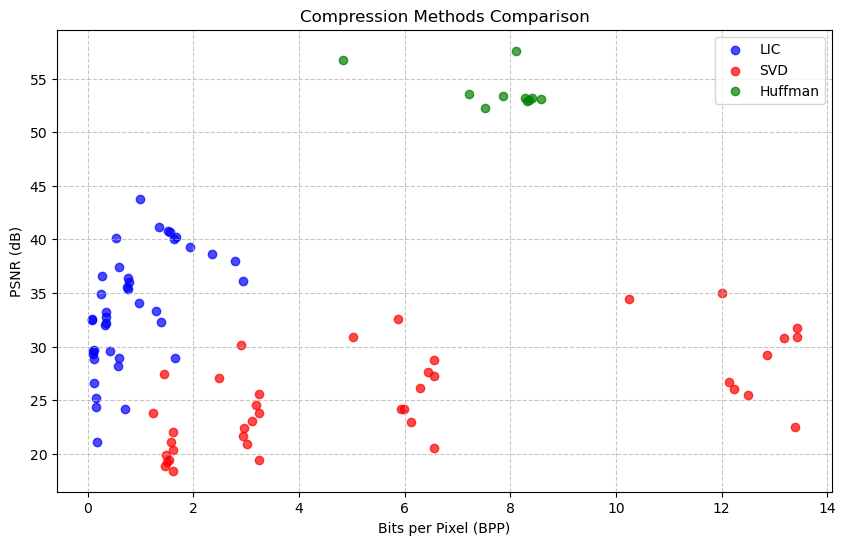

In [13]:
# extract results
lic_psnr = [t[0] for sublist in lic_results.values() for t in sublist]
lic_bpp = [t[1] for sublist in lic_results.values() for t in sublist]

svd_psnr = [t[0] for sublist in svd_results.values() for t in sublist]
svd_bpp = [t[1] for sublist in svd_results.values() for t in sublist]

huffman_psnr = [t[0] for t in huffman_results]
huffman_bpp = [t[1] for t in huffman_results]

# Create the scatter plot
plt.figure(figsize=(10, 6))

plt.scatter(lic_bpp, lic_psnr, c='blue', label='LIC', alpha=0.7)
plt.scatter(svd_bpp, svd_psnr, c='red', label='SVD', alpha=0.7)
plt.scatter(huffman_bpp, huffman_psnr, c='green', label='Huffman', alpha=0.7)

# Customize the plot
plt.xlabel('Bits per Pixel (BPP)')
plt.ylabel('PSNR (dB)')
plt.title('Compression Methods Comparison')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()